In [1]:
# !pip install keras==2.15.0

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import re
import string
import gensim
from gensim.models import FastText
import random
from tabulate import tabulate
from tqdm import tqdm
import tensorflow as tf

2024-10-14 13:36:16.160707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 13:36:16.160808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 13:36:16.290057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# import nltk

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
       
# from nltk.corpus import stopwords, wordnet
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

In [4]:
import nltk
import subprocess
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('punkt', download_dir='/kaggle/working/')
    nltk.download('wordnet', download_dir='/kaggle/working/')
    nltk.download('stopwords', download_dir='/kaggle/working/')
    nltk.download('wordnet', download_dir='/kaggle/working/')
    nltk.download('averaged_perceptron_tagger', download_dir='/kaggle/working/')
    
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
    
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /kaggle/working/...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  infl

# Reading the file

In [5]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)

df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.shape

(1600000, 6)

In [7]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
# Define a dictionary to map sentiment values
sentiment_mapping = {0: "Negative", 4: "Positive"}

# Map the 'sentiment' column using the defined dictionary
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


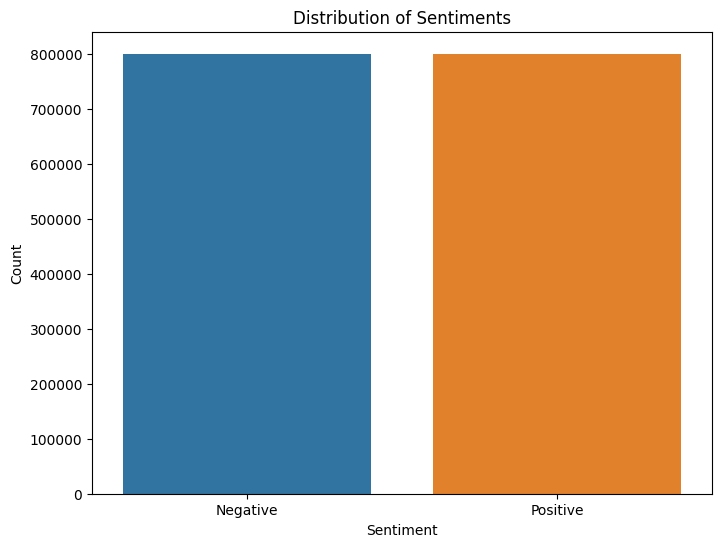

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment category
sentiment_counts = df['sentiment'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Adding labels and title
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show plot
plt.show()

# Taking a sample from the data

/tmp/ipykernel_34/2544916116.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(int(sample_size/2)))


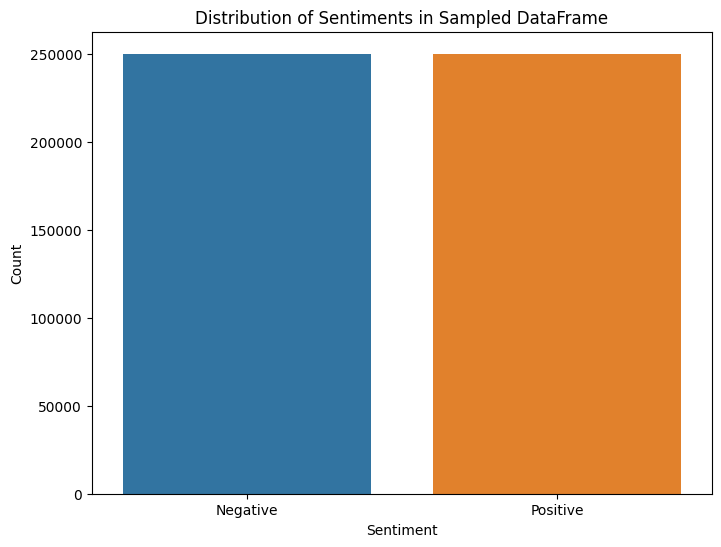

In [11]:
# Generate a sample DataFrame with the same distribution of classes
sample_size = 500000

# Randomly sample 100000 rows from each class
sampled_df = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(int(sample_size/2)))

# Reset the index of the sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)

# Count the occurrences of each sentiment category in the sampled DataFrame
sentiment_counts = sampled_df['sentiment'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Adding labels and title
plt.title('Distribution of Sentiments in Sampled DataFrame')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show plot
plt.show()

# Applying Preprocessing on the data

In [12]:
def remove_usernames(text):
    # Remove usernames (mentions) from the text
    return re.sub(r'@\w+', '', text)

def tokenize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return tokens

def normalize_tokens(tokens):
    # Normalize tokens to lowercase
    normalized_tokens = [token.lower() for token in tokens]
    return normalized_tokens

def clean_tokens(tokens):
    # Filter out non-alphanumeric tokens
    cleaned_tokens = [token for token in tokens if token.isalnum() and not token.isdigit()]
    return cleaned_tokens

def remove_stopwords(tokens):
    # Remove stop words from tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

def lemmatize_tokens(tokens):
    # Lemmatize tokens based on part of speech
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        pos_tag = nltk.pos_tag([token])[0][1][0].upper()
        pos_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
        wordnet_pos = pos_map.get(pos_tag, wordnet.NOUN)
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmatized_tokens.append(lemma)
    return lemmatized_tokens

def filter_meaningful_tokens(tokens):
    # Filter tokens based on length and presence in WordNet
    meaningful_tokens = [token for token in tokens if len(token) >= 3]
    return meaningful_tokens

def preprocess_text(text):
    # Step 1: Remove usernames
    text = remove_usernames(text)

    # Step 2: Tokenize text
    tokens = tokenize_text(text)
    
    # Step 3: Normalize tokens
    normalized_tokens = normalize_tokens(tokens)
    
    # Step 4: Clean tokens
    cleaned_tokens = clean_tokens(normalized_tokens)
    
    # Step 5: Remove stop words
    filtered_tokens = remove_stopwords(cleaned_tokens)
    
    # Step 6: Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)
    
    # Step 7: Filter meaningful tokens
    meaningful_tokens = filter_meaningful_tokens(lemmatized_tokens)
    
    # Join tokens into preprocessed text
    preprocessed_text = ' '.join(meaningful_tokens)
    
    return preprocessed_text

In [13]:
import pandas as pd
from tqdm import tqdm

# Initialize tqdm with pandas apply function
tqdm.pandas()

# Assuming sampled_df is your DataFrame and preprocess_text is your preprocessing function
sampled_df['cleaned_text'] = sampled_df['text'].progress_apply(preprocess_text)

# Display the DataFrame with cleaned text
print(sampled_df.head(10))

100%|██████████| 500000/500000 [15:01<00:00, 554.72it/s]

  sentiment                                               text  \
0  Negative  @counterBurger WHAT?!!!!!!!!! Omg I love that ...   
1  Negative                              So behind on e-mail.    
2  Negative  @stevenporto AHHH are you gonna be around tomo...   
3  Negative  Bad news about @hotpatooties podcast. I'm revi...   
4  Negative  I apologize for the delay in updates. Been hav...   
5  Negative  @Parquette1know what you mean.have been at wor...   
6  Negative  @sammyjuddmcfly oh..  You'll be better, ok! I ...   
7  Negative   I seem to have found a bug in HotSpot. My GLL...   
8  Negative  Fucking pissed about how tonight went down! Lo...   
9  Negative  Is lying in bed watching a dvd but wants a cwt...   

                                        cleaned_text  
0                       omg love man wish saw mobbed  
1                                             behind  
2          ahhh gon around tomorrow cause movin good  
3  bad news podcast revise tomorrow listen wed li... 

In [14]:
# Define the file path and name for the CSV file
csv_file_path = '/kaggle/working/sample_dataframe.csv'

# Export the DataFrame to CSV
sampled_df.to_csv(csv_file_path, index=False)

print(f"DataFrame has been exported to {csv_file_path}.")

DataFrame has been exported to /kaggle/working/sample_dataframe.csv.


# Splitting the data

In [15]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X = sampled_df['cleaned_text']
y = sampled_df['sentiment']

# Splitting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y , random_state=42)

# Convert sentiment labels to numerical format
y_train_numeric = (y_train == 'Positive').astype(int)
y_test_numeric = (y_test == 'Positive').astype(int)

# Displaying the shapes of the new DataFrames
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (400000,)
Testing data shape: (100000,)


# Usign FastText to get the embeddings of the data

In [16]:
# Convert 'cleaned_text' from training data (X_train) to list of sentences
train_sentences = [text.split() for text in X_train]

# Train FastText model
model = FastText(sentences=train_sentences, vector_size=30, window=2, min_count=1, sg=1, epochs=100)

# Preparing the data before feeding it into the Model

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

# Tokenize and convert text data to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Save the tokenizer after fitting
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved to tokenizer.pkl")

Tokenizer saved to tokenizer.pkl


In [19]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to ensure uniform length
max_len = 30
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

In [21]:
# Prepare embedding matrix from FastText model
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, 30))  # vector_size=30 in FastText
for word, i in word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]

# Model Preparing and Training

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.initializers import Constant

# Build the simplified LSTM model
model = Sequential()

# Embedding layer using the embedding_matrix
embedding_layer = Embedding(input_dim=vocab_size, 
                             output_dim=30, 
                             embeddings_initializer=Constant(embedding_matrix), 
                             input_length=max_len, 
                             trainable=True)  # Set trainable to True if you want to fine-tune the embeddings
model.add(embedding_layer)

# Single LSTM layer
model.add(LSTM(50, dropout=0.2))  # Reduced units and dropout

# Fully connected layer with fewer units
model.add(Dense(8, activation='relu'))  # Reduced units

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model with numerical labels and store the training history
history = model.fit(X_train_padded, y_train_numeric, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 181s 36ms/step - accuracy: 0.7304 - loss: 0.5325 - val_accuracy: 0.7731 - val_loss: 0.4743
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 179s 36ms/step - accuracy: 0.7741 - loss: 0.4694 - val_accuracy: 0.7778 - val_loss: 0.4659
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 181s 36ms/step - accuracy: 0.7859 - loss: 0.4496 - val_accuracy: 0.7772 - val_loss: 0.4743
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 182s 36ms/step - accuracy: 0.7966 - loss: 0.4330 - val_accuracy: 0.7783 - val_loss: 0.4698
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 179s 36ms/step - accuracy: 0.8070 - loss: 0.4160 - val_accuracy: 0.7751 - val_loss: 0.4732


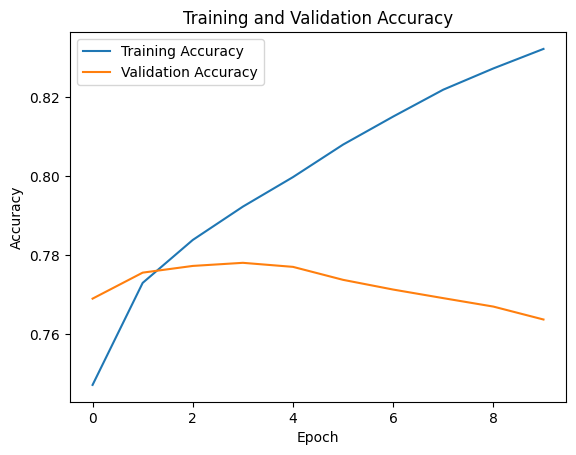

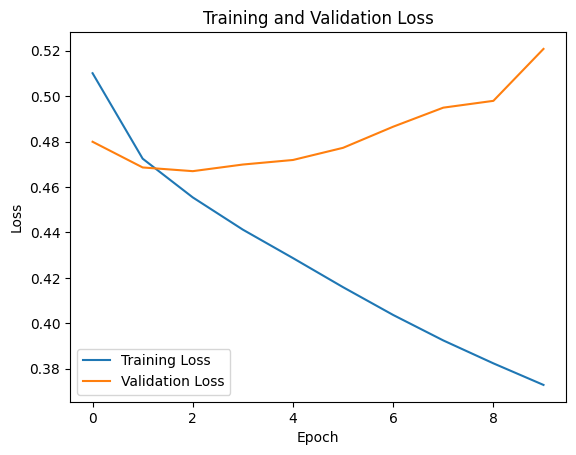

In [24]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step


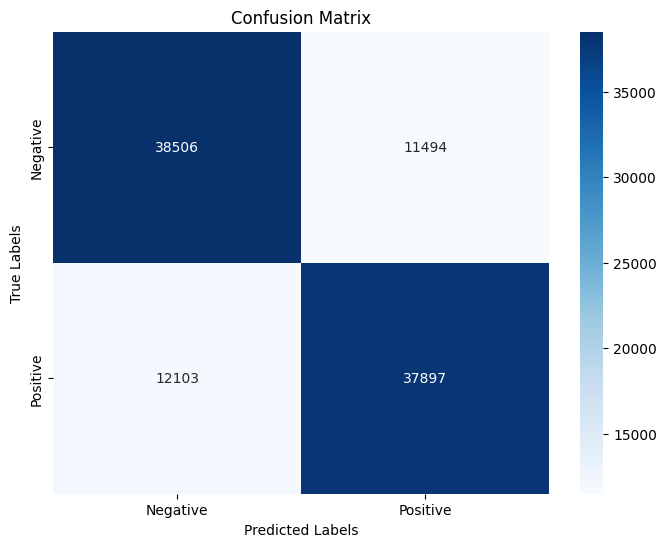

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77     50000
           1       0.77      0.76      0.76     50000

    accuracy                           0.76    100000
   macro avg       0.76      0.76      0.76    100000
weighted avg       0.76      0.76      0.76    100000



In [25]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict classes on test data
y_pred = (model.predict(X_test_padded) > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_numeric, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Display classification report
report = classification_report(y_test_numeric, y_pred)
print("Classification Report:")
print(report)

# Model Testing Example

In [26]:
# Ensure X_test and y_test_numeric are numpy arrays
X_test_array = X_test.values if isinstance(X_test, pd.Series) else np.array(X_test)
y_test_array = y_test_numeric.values if isinstance(y_test_numeric, pd.Series) else np.array(y_test_numeric)

# Select 10 random indices
random_indices = random.sample(range(len(X_test_array)), 10)

# Prepare data for the table
table_data = []
for idx, rand_idx in enumerate(random_indices, start=1):
    sentence = X_test_array[rand_idx]
    true_label = "Positive" if y_test_array[rand_idx] == 1 else "Negative"
    predicted_label = "Positive" if y_pred[rand_idx] == 1 else "Negative"
    table_data.append([idx, sentence, true_label, predicted_label])

# Create headers for the table
headers = ["Index", "Sentence", "True Label", "Predicted Label"]

# Display the table with 'fancy_grid' format
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒═════════╤═══════════════════════════════════════════════════════════════════════════════════╤══════════════╤═══════════════════╕
│   Index │ Sentence                                                                          │ True Label   │ Predicted Label   │
╞═════════╪═══════════════════════════════════════════════════════════════════════════════════╪══════════════╪═══════════════════╡
│       1 │ damn see foto                                                                     │ Negative     │ Negative          │
├─────────┼───────────────────────────────────────────────────────────────────────────────────┼──────────────┼───────────────────┤
│       2 │ yes alto great 2nd good harmonizer                                                │ Positive     │ Positive          │
├─────────┼───────────────────────────────────────────────────────────────────────────────────┼──────────────┼───────────────────┤
│       3 │ try get offtoday luck could get organize today icky doubly wish could s

# Saving the Model

In [27]:
# Save the model in HDF5 format
model.save('sentiment_analysis_model.h5')